<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Names and NetIDs for your group members: Michael Guan(mhg99), Enoch Kim (ek537), Ashrafur Siddiqui (as3273)




<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

![image.png; width="100";](attachment:image.png)

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [ ]:
import os
import pandas as pd
import numpy as np
# TODO
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# tqdm gives us nice progress bars, which provide a huge quality-of-life boost,
# so it's worth mentioning here.
from tqdm import tqdm

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [ ]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. # Here is SVM, 
# Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [ ]:
# You may change this but we suggest loading data with the following code and you may need to change
# datatypes and do necessary data transformation after loading the raw data to the dataframe.
# df = pd.read_csv(dataset_path, sep=',',header=None, encoding='unicode_escape')

# Make sure you comment your code clearly and you may refer to these comments in the part 2.4
# TODO
dataset_path = "/content/train_2016.csv"
df = pd.read_csv(dataset_path, sep=',',header=None, encoding='unicode_escape')

# FIPS and County represent the "same" data, only need FIPS here
df_clean = df.drop(1, axis=1)

#Removed the headers from the data
df_clean = df_clean.drop(0, axis=0)

#Change the type from string (remove comma) to float
df_clean = df_clean.apply(lambda x: x.str.replace(',', '').astype(np.double), axis=1)

#Get y values GOP: 0, DEM: 1 
y = df_clean[2] > df_clean[3] 
y = y.astype(int)

#Remove the votes
df_clean = df_clean.drop(2, axis=1)
df_clean = df_clean.drop(3, axis=1)

def normalize(df, mean, std):
    # x = df.values #returns a numpy array
    # #Transforms each colums of x on a 0-1 scale
    # min_max_scaler = preprocessing.MinMaxScaler() 
    # x_scaled = min_max_scaler.fit_transform(x)
    return (df.to_numpy()-mean)/std

mean = df_clean.mean().to_numpy()
std = df_clean.std().to_numpy()

df_norm = normalize(df_clean, mean, std)
df_norm_f = normalize(df_clean.drop(0, axis=1), mean[1:], std[1:])

def prep(path, mean, std):
    #This is for the actual test data (we get the DEM and GOP numbers in train)
    dataset_path = path
    df = pd.read_csv(dataset_path, sep=',',header=None, encoding='unicode_escape')
    # print(df)
    df_clean = df.drop(1, axis=1)
    df_clean = df_clean.drop(0, axis=0)
    df_clean = df_clean.apply(lambda x: x.str.replace(',', '').astype(float), axis=1)
    # print(df_clean)
    df_norm = normalize(df_clean, mean, std)
    # print("regnorm")
    df_norm_f = normalize(df_clean.drop(0, axis=1), mean[1:], std[1:])
    return df.to_numpy(), df_clean.to_numpy(), df_norm, df_norm_f


<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [ ]:
# Make sure you comment your code clearly and you may refer to these comments in the part 2.4


#Algorithm 1: SVM
clf_svm = svm.SVC(kernel='rbf') 
clf_svm_f = svm.SVC(kernel='rbf') 
#Algorithm 2: Bayes
clf_bayes = GaussianNB()
clf_bayes_f = GaussianNB()

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [ ]:
# Make sure you comment your code clearly and you may refer to these comments in the part 2.4
# TODO

x_train, x_test, y_train, y_test = train_test_split(df_norm, y, test_size=0.2, random_state=42)

#no fips
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(df_norm_f, y, test_size=0.2, random_state=42)
# x_train_f = x_train_f.to_numpy()
y_train_f = y_train_f.to_numpy()
# x_test_f = x_test_f.to_numpy()
y_test_f = y_test_f.to_numpy()

#Split train and test
#Kfold on train
#double for loop for C value optimization
#train on C* eval on test

kf = KFold(n_splits=6)
Cstar = 1
Cscore = 0
for c in range(3500,3505,1):
  # print(c)
  score = 0
  count = 0
  for train_index, test_index in kf.split(x_train_f):
      x_train_k, x_test_k = x_train_f[train_index],  x_train_f[test_index]
      y_train_k, y_test_k = y_train_f[train_index],  y_train_f[test_index]
      clf_svm_k = svm.SVC(kernel='rbf', C=c) 
      clf_svm_k.fit(x_train_k, y_train_k)
      y_pred = clf_svm_k.predict(x_test_k)
      score += weighted_accuracy(y_pred, y_test_k)
      count += 1
  score = score/count
  if (score > Cscore):
      # print("better c value", c, Cstar)
      Cstar = c
      Cscore = score
#print("C*: ", Cstar, Cscore)
clf_svm_k = svm.SVC(kernel='rbf', C=Cstar) 
clf_svm_k.fit(x_train_f, y_train_f)
y_pred = clf_svm_k.predict(x_test_f)

#print("(No FIPS) K-fold SVM Accuracy:",weighted_accuracy(y_pred, y_test_f))

clf_svm_f.fit(x_train_f, y_train_f)
y_pred = clf_svm_f.predict(x_test_f)

#print("(No FIPS) SVM Accuracy:",weighted_accuracy(y_pred, y_test_f))

clf_bayes_f.fit(x_train_f, y_train_f)
y_pred = clf_bayes_f.predict(x_test_f)

#print("(No FIPS) Bayes Accuracy:",weighted_accuracy(y_pred, y_test_f))

clf_svm.fit(x_train, y_train)
y_pred = clf_svm.predict(x_test)

#print("(FIPS) SVM Accuracy:",weighted_accuracy(y_pred, y_test))

clf_bayes.fit(x_train, y_train)
y_pred = clf_bayes.predict(x_test)



#print("(FIPS) Bayes Accuracy:",weighted_accuracy(y_pred, y_test))

"""
(No FIPS) K-fold SVM Accuracy: 0.7247412008281574
(No FIPS) SVM Accuracy: 0.5659937888198757
(No FIPS) Bayes Accuracy: 0.6782608695652174
(FIPS) SVM Accuracy: 0.5659937888198757
(FIPS) Bayes Accuracy: 0.6639751552795031
"""


'\n(No FIPS) K-fold SVM Accuracy: 0.7247412008281574\n(No FIPS) SVM Accuracy: 0.5659937888198757\n(No FIPS) Bayes Accuracy: 0.6782608695652174\n(FIPS) SVM Accuracy: 0.5659937888198757\n(FIPS) Bayes Accuracy: 0.6639751552795031\n'

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features?

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

2.4.3 How did you do the model selection?

2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)


2.4.1 How did you preprocess the dataset and features?

We first got rid of sections of the training data we decided should not be on a Training vector. This included FIPS and County. The identification number and county name should have no correlation to the votes. We also removed Dem and GOP columns and converted them into our y values, 0 means Dem win and 1 for GOP win. We also had to convert the numbers from strings into numeric values. This meant we had to remove the commas. We then normalized the data from 0 to 1 to make numbers mean something relative to the other data. 
 
2.4.2 Which two learning methods from class did you choose and why did you make the choices?

We chose a Kernelized SVM because we thought that it would perform well with the data given to us. We hoped that in some dimension it would be separable. We then did a Naive Bayes training algorithm. We chose this because we thought that certain features such as median income, bachelor rate and unemployment rate would have more drastic effects on the outcome of the county. For example, High Bachelor rate may imply a more college graduates which have shown to vote more democratic in recent studies.
 
2.4.3 How did you do the model selection?

We split the data into a training set and a validation set. We then performed K-fold cross validation where there were 6 splits so that there was enough data to train on. We also optimized the C value for our SVM function.
 
2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)
 
Yes it does.
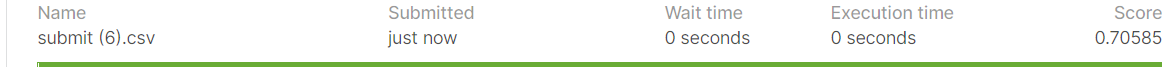

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [ ]:
import os
import pandas as pd
import numpy as np
# TODO
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# tqdm gives us nice progress bars, which provide a huge quality-of-life boost,
# so it's worth mentioning here.
from tqdm import tqdm
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# You may change this but we suggest loading data with the following code and you may need to change
# datatypes and do necessary data transformation after loading the raw data to the dataframe.
# df = pd.read_csv(dataset_path, sep=',',header=None, encoding='unicode_escape')

# Make sure you comment your code clearly and you may refer to these comments in the part 2.4
# TODO
#dataset_path = "/content/train_2016.csv"
dataset_path = "/content/train_2016.csv"
dataset_path2 = "/content/train_2012.csv"
dataset_path3 = "/content/test_2016_no_label.csv"
df = pd.read_csv(dataset_path, sep=',',header=None, encoding='unicode_escape')
#df2 = pd.read_csv(dataset_path2, sep=',',header=None, encoding='unicode_escape')
#df2 = df2.drop(0, axis = 0)
#df = df.append(df2)

# FIPS and County represent the "same" data, only need FIPS here
df_clean = df.drop(1, axis=1)

#Removed the headers from the data
df_clean = df_clean.drop(0, axis=0)

#Change the type from string (remove comma) to float
df_clean = df_clean.apply(lambda x: x.str.replace(',', '').astype(np.double), axis=1)

#Get y values GOP: 0, DEM: 1 
y = df_clean[2] > df_clean[3] 
y = y.astype(int)

#Remove the votes
df_clean = df_clean.drop(2, axis=1)
df_clean = df_clean.drop(3, axis=1)

#Add Features
df_clean[10] = df_clean[5] + df_clean[6] + df_clean[7] #Population Change
df_clean[11] = df_clean[8]/df_clean[9] #Ratio of Edu to Unemployment
df_clean[12] = df_clean[10]*df_clean[4] # Pop change * Median
df_clean[13] = df_clean[11]*df_clean[4] # Edu/unemplyment * Median 
df_clean[14] = df_clean[10]*df_clean[11] #Ratio among new population


def normalize(df, mean, std):
    return (df.to_numpy()-mean)/std

mean = df_clean.mean().to_numpy()
std = df_clean.std().to_numpy()


df_norm = normalize(df_clean, mean, std)
df_norm_f = normalize(df_clean.drop(0, axis=1), mean[1:], std[1:])

def prep(path, mean, std):
    #This is for the actual test data (we get the DEM and GOP numbers in train)
    dataset_path = path
    df = pd.read_csv(dataset_path, sep=',',header=None, encoding='unicode_escape')
    df_clean = df.drop(1, axis=1)
    df_clean = df_clean.drop(0, axis=0)
    df_clean = df_clean.apply(lambda x: x.str.replace(',', '').astype(float), axis=1)
    
    #Add Features
    df_clean[8] = df_clean[3] + df_clean[4] + df_clean[5]
    df_clean[9] = df_clean[6]/df_clean[7]
    df_clean[10] = df_clean[8]*df_clean[2]
    df_clean[11] = df_clean[9]*df_clean[2]
    df_clean[12] = df_clean[8]*df_clean[9]


    df_norm = normalize(df_clean, mean, std)
    df_norm_f = normalize(df_clean.drop(0, axis=1), mean[1:], std[1:])
    return df.to_numpy(), df_clean.to_numpy(), df_norm, df_norm_f


#print("DATA PREPED")


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

#Use no FIPS
x_train, x_test, y_train, y_test = train_test_split(df_norm_f, y, test_size=0.2, random_state=42)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

In [ ]:


"""
Three step process for machine learning, ignoring a bunch of important things
we talked about in class:

1. Get data
    1.1 Get a Dataset---this is provided by PyTorch
    1.2 Get a DataLoader---this is provided by PyTorch
2. Get a classifier, and other paraphenalia needed for training
    2.1 Create a classifier architecture, and instantiate it
    2.2 Get a criterion (loss function)
    2.3 Get an optimizer (thing that does parameter updates to the classifier)
3. Classify the data in some reasonably intelligent fashion. This will involve:
    3.1 A one_epoch() function that trains the classifier for one epoch---a
        complete iteration over the dataset from (1.1)
    3.2 A loop that calls one_epoch() the number of times we want to run an
        epoch.
4. ...
5. $$$
"""

# 'something_from_torch = something_from_torch.to(device)' puts the thing onto
# the device. If you have CUDA available, this will massively speed
# computations. Note that all inputs to a computation must be on the same
# device, and that things are on the CPU by default.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setting a random seed means we can reproduce our results easily. In my
# understanding, this is generally good practice.
np.random.seed(4780)
torch.manual_seed(4780)

# Here I define a bunch of constants that'll be needed later on. I've chosen the
# first two arbitrarily; the last three are set to values that are probably
# decent across a wide range of tasks.
input_dim = 11          # This is the dimensionality of the inputs X
output_dim = 2         # This is the number of classes in Y
num_workers = 4         # We want to parallelize loading data during training.
                        #   Otherwise, it's possible for moving data to model to
                        #   become a bottleneck in performance!
batch_size = 16        # This is the number of examples (x,y) that are run
                        #   through the neural net simultaneously. Think of it as
                        #   a mid-ground between SGD and GD.
num_epochs = 100       # The number of complete iterations over the dataset
                        #   made during training

save_file = "best_model.pt" # It's helpful to save the best-performing model
                            #   throughout training...

# 1.1---get the Dataset. A Dataset should extend PyTorch's base class, and needs
# to do two things:
# a) implement the __getitem__() method. This takes in an index to the data and
#       returns the x- and y-values of the ith datapoint, often as tensors.
# b) implement the __len__() method. This is just the amount of data in the
#       dataset.
class CountyDataset(Dataset):
    """An example dataset."""
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, i):
        return torch.tensor(self.x[i]).float(), torch.tensor(np.array(self.y[i])).long()

    def __len__(self):
        return len(self.x)

        

train_dataset = CountyDataset(x_train, y_train)


val_dataset = CountyDataset(x_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)


# 1.2---get a DataLoader. This wraps a Dataset and allows you to iterate through
# it. It's also where you can implement *a lot* of performance optimizations.
# 'shuffle=True' is set by default, but it's worth emphasizing here.
#
# As long as values for 'batch_size' are reasonable (4 <= x << amount of data),
# changing it will mostly change the speed and not performance of the model.
# 'num_workers' should be just under your number of CPUs.
train_loader = DataLoader(train_dataset,
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers)
    
# 2.1---here we define the actual neural net! It should be a class that inherits
# from torch.nn.Module, and has a forward() method that implements the function
#
#       f : X -> Y
#
# Because the neural net is *literally* a function, I'll call its outputs on an
# input 'x' 'fx'.
class NeuralNet(nn.Module):
    
    # As you know, a neural net is composed of layers. The first layer takes in
    # an example x, does a computation on it, and passes the result fx to the
    # second layer, and this process continues.
    #
    # Note that the architecture below illustrates how to build a neural net,
    # but shouldn't work too well otherwise.
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.f1 = nn.Linear(input_dim , 4) 
        self.r1 = nn.ReLU()  
        self.f2 = nn.Linear(4, 5)
        self.r2 = nn.ReLU()  
        self.f3 = nn.Linear(5, 2)
        self.r3 = nn.ReLU()          
        self.fc = nn.Linear(2, output_dim)  
                                            
    # Don't worry about adding an activation function at the end. It's done
    # automatically in the loss function! Of course, this means the outputs of
    # the model need to be softmaxed before they can be used as probabilities.
    
    # This is the function that implements f : X -> Y. Note that we can expand
    # it as fc(r1(f1(x)))))!
    def forward(self, x):
        fx = self.f1(x)
        fx = self.r1(fx)
        fx = self.f2(fx)
        fx = self.r2(fx)
        fx = self.f3(fx)
        fx = self.r3(fx)
        return self.fc(fx)
        
# Instantiate the model! We need to move it to whatever device it'll be running
# on before we instantiate the optimizer in 2.3.
model = NeuralNet(input_dim, output_dim).to(device)

# 2.2---The criterion is the loss function. Normally, you use CrossEntropy for a
# classification task. (Binary classification is a special case where you can
# get away with doing something else like 0-1 loss.)
criterion = nn.CrossEntropyLoss()

# 2.3---The optimizer takes care of the parameter updates via its step() method.
# To make it work, we need to pass in the 'parameters' of the model. Generally,
# you'll choose between Adam and SGD.
optimizer = optim.Adam(model.parameters(), lr = .01)

# 3.1---I find it's useful to define a function implementing a single epoch, and
# then call it repeatedly from within a loop to train the neural net.
def one_epoch(model, train_loader, optimizer, criterion):
    """Returns [model] after being trained for one epoch on [data_loader] using
    [optimizer] and [criterion].
    """
    # [data_loader] returns batches of paired x- and y-values when we iterate
    # over it. Because of PyTorch magic, we don't have to worry about the batch
    # size!
    #
    # What is tqdm doing here? When we wrap an iterable in tqdm() during
    # iteration, we get a super nice progress bar!
    for x,y in tqdm(train_loader, desc="Running batches...", leave=False):
        # x is a tensor of dimension (batch_size x n_features), y is a tensor of
        # dimension (batch_size,). If they're not on the same device as [model],
        # they need to be moved there. (Note that it might be smarter to
        # accomplish this through the DataLoader.)
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()   # We only want to accumulate the gradient for
                                #   the current batch. Therefore, we zero out
                                #   the gradient of the model.
        fx = model(x.float())           # Compute predictions for a batch 'x'
        torch.flatten(y)
        loss = criterion(fx, y) # Compute the loss function's value on the
                                #   outputs of the model on 'x' and the true
                                #   labels 'y'
        loss.backward()         # Compute the gradients of the model's weights
                                #   with respect to the loss.
        optimizer.step()        # Update parameters by taking an intelligent
                                #   optimizer-determined step against the
                                #   gradient.
        
    # When the epoch is over, return the model.
    return model

# We can keep track of when after an epoch finishes our model has a better
# validation accuracy than anything else using this. We'll also need a function
# to compute validation accuracy!
best_val_acc = float("-inf")

def validate(model, val_loader):
    """Returns the accuracy of [model] on [val_loader]."""
    
    def batch_acc(x, y):
        """Returns the number of correct predictions of [model] on [x] given
        [y].
        """
        # Note that PyTorch can do most things that NumPy can. model(x) returns
        # a batch of predictions as a (batch_size x n_classes) tensor; y is a
        # (n_examples,) tensor of in which the i^th index contains the class of
        # the i^th example, eg. 5.
        #
        # Additionally, [model] is on [device], so you'll need to move [x] to
        # the device prior to computation. To move a tensor [t] to the CPU you
        # can call 't.cpu()'---this might be useful for comparing with [y].
        #
        # Can you fit this all on one line?
        # print("YOOOOOOO", np.argmax(model(x).numpy(), axis=1) == y.numpy())
        return np.sum(np.argmax(model(x).numpy(), axis=1) == y.numpy())
    
    # The length of a Dataset is the number of examples in it; the length of a
    # DataLoader is the number of batches. Therefore, to get the accuracy, it's
    # critical to divide by the length of the first and not the second!
    #
    # We can use NumPy here because it's generally (in my experience) faster for
    # things on the CPU than PyTorch.
    # print("Poggers")
    # print(np.sum([batch_acc(x, y) for x,y in val_loader]))
    # print(len(val_dataset))
    return np.sum([batch_acc(x, y) for x,y in val_loader]) / len(val_dataset)

# 3.2---Train the model on the entirety of the data once for every desired
# epoch. tqdm gives a nice progress bar.
for e in tqdm(range(num_epochs), desc="Running epochs..."):
    model = one_epoch(model, train_loader, optimizer, criterion)
    
    # Suppose we wanted to find the validation accuracy after epoch! All we'd
    # need would be a validation DataLoader, and a function to get accuracy
    # from! Putting this under 'with torch.no_grad():' turns off computing
    # gradients, because we don't need them. Moreover, wrapping it in
    # 'model.eval()' and 'model.train()' is important if we do fancy things like
    # dropout.
    with torch.no_grad():
        model.eval()
        val_acc = validate(model, val_loader)
        model.train()
    
    # When in the middle of a tqdm-ed loop, we need to use 'tqdm.write()'
    # instead of 'print()'.
    tqdm.write(f"Epoch {e:3} | validation accuracy: {val_acc}")
    
    # If the validation accuracy is the highest it's ever been, why not save the
    # the model? This is a natural way to figure out the correct number of
    # epochs!
    if val_acc > best_val_acc:
        tqdm.write(f"------Best epoch yet with accuracy {val_acc}. Saved!")
        best_val_acc = val_acc
        
        # Saving a PyTorch model is super easy! 'model.state_dict()' converts
        # all of its weights to a dictionary format. The general format here is
        # 'torch.save(dictionary, file)'. Note that we can put basically
        # anything we want in this dictionary too!
        torch.save(model.state_dict(), save_file)
        
# Now that training is done, let's load the best model so we can do something
# with it. First, we need to instantiate a new model of the same type as the
# old one. Then we can call 'load_state_dict()' on the loaded state_dict.
model = NeuralNet(input_dim, output_dim)
best_val_acc_model_weights = torch.load(save_file)
model.load_state_dict(best_val_acc_model_weights)

################################################################################
### WANT TO SEE THE CODE RUN? PASTE THE FOLLOWING CODE DIRECTLY ABOVE 1.2, THEN
### IMPLEMENT 'batch_acc()'.
### It's way beyond the scope of the course though still far too simple for the
### task it takes on; I use it to validate what I've written elsewhere. Also
### note that it downloads the MNIST (handwritten images) dataset to your
### computer, so beware...though you really can just delete it later.
###
### Aside: you should be able to get at least 95% accuracy on the MNIST dataset
### without trying. This gets up to about 70% accuracy because I deliberately
### wrote the worst neural net I could think of that'd illustrate what I needed
### to show.
################################################################################
# import torchvision
# from torchvision import transforms
# from torch.utils.data import Subset
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda t: torch.flatten(t)),
# ])
# dataset = torchvision.datasets.MNIST("./MNIST/",
#     train=True, transform=transform, download=True)
# train_dataset = Subset(dataset, range(0, 10000))
# val_dataset = Subset(dataset, range(10000, 11000))
# val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4)
# input_dim, output_dim, num_epochs = 784, 10, 100




Running epochs...:   0%|          | 0/100 [00:00<?, ?it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Running batches...:  10%|█         | 8/78 [00:00<00:00, 78.71it/s]

Running batches...:  33%|███▎      | 26/78 [00:00<00:00, 94.20it/s]

Running batches...:  65%|██████▌   | 51/78 [00:00<00:00, 115.09it/s]

Running batches...:  97%|█████████▋| 76/78 [00:00<00:00, 137.09it/s]


Running batches...:  85%|████████▍ | 66/78 [5:09:20<00:00, 124.02it/s]

Running epochs...:   1%|          | 1/100 [00:00<01:01,  1.60it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   0 | validation accuracy: 0.887459807073955
------Best epoch yet with accuracy 0.887459807073955. Saved!




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.50it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 51.70it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 67.34it/s]


Running batches...:  85%|████████▍ | 66/78 [5:09:20<00:00, 124.02it/s]

Running epochs...:   2%|▏         | 2/100 [00:01<01:00,  1.62it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   1 | validation accuracy: 0.9003215434083601
------Best epoch yet with accuracy 0.9003215434083601. Saved!




Running batches...:   3%|▎         | 2/78 [00:00<00:03, 19.90it/s]

Running batches...:  33%|███▎      | 26/78 [00:00<00:01, 27.44it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 37.51it/s]


Running batches...:  85%|████████▍ | 66/78 [5:09:21<00:00, 124.02it/s]

Running epochs...:   3%|▎         | 3/100 [00:01<00:58,  1.65it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   2 | validation accuracy: 0.9131832797427653
------Best epoch yet with accuracy 0.9131832797427653. Saved!




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 29.88it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:01, 40.68it/s]

Running batches...:  72%|███████▏  | 56/78 [00:00<00:00, 54.57it/s]


Running epochs...:   4%|▍         | 4/100 [00:02<00:57,  1.68it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   3 | validation accuracy: 0.9067524115755627




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.94it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:00, 53.24it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 69.30it/s]

Running batches...:  96%|█████████▌| 75/78 [00:00<00:00, 87.66it/s]


Running epochs...:   5%|▌         | 5/100 [00:02<00:56,  1.68it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   4 | validation accuracy: 0.9131832797427653




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.39it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:00, 51.08it/s]

Running batches...:  63%|██████▎   | 49/78 [00:00<00:00, 66.27it/s]

Running batches...:  90%|████████▉ | 70/78 [00:00<00:00, 83.34it/s]


Running epochs...:   6%|▌         | 6/100 [00:03<00:56,  1.65it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   5 | validation accuracy: 0.9131832797427653




Running batches...:   9%|▉         | 7/78 [00:00<00:01, 69.56it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 88.71it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 109.99it/s]


Running epochs...:   7%|▋         | 7/100 [00:04<00:55,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   6 | validation accuracy: 0.8938906752411575




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 28.71it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:01, 38.95it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 52.10it/s]


Running epochs...:   8%|▊         | 8/100 [00:04<00:54,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   7 | validation accuracy: 0.9131832797427653




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.79it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 65.60it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 82.94it/s]


Running epochs...:   9%|▉         | 9/100 [00:05<00:53,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   8 | validation accuracy: 0.9003215434083601




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.07it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 51.12it/s]

Running batches...:  72%|███████▏  | 56/78 [00:00<00:00, 67.18it/s]


Running epochs...:  10%|█         | 10/100 [00:05<00:52,  1.72it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch   9 | validation accuracy: 0.9003215434083601




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.28it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 64.66it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 82.39it/s]


Running epochs...:  11%|█         | 11/100 [00:06<00:51,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  10 | validation accuracy: 0.8906752411575563




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.83it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 76.26it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 96.51it/s]


Running epochs...:  12%|█▏        | 12/100 [00:07<00:51,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  11 | validation accuracy: 0.9035369774919614




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.57it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 51.73it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 67.01it/s]

Running batches...:  96%|█████████▌| 75/78 [00:00<00:00, 84.96it/s]


Running epochs...:  13%|█▎        | 13/100 [00:07<00:51,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  12 | validation accuracy: 0.909967845659164




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.14it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 64.61it/s]

Running batches...:  69%|██████▉   | 54/78 [00:00<00:00, 82.72it/s]


Running epochs...:  14%|█▍        | 14/100 [00:08<00:50,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  13 | validation accuracy: 0.8938906752411575




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.88it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 53.25it/s]

Running batches...:  69%|██████▉   | 54/78 [00:00<00:00, 69.55it/s]


Running epochs...:  15%|█▌        | 15/100 [00:08<00:49,  1.72it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  14 | validation accuracy: 0.9067524115755627




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.79it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 76.40it/s]

Running batches...:  74%|███████▍  | 58/78 [00:00<00:00, 96.51it/s]


Running epochs...:  16%|█▌        | 16/100 [00:09<00:48,  1.73it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  15 | validation accuracy: 0.9131832797427653




Running batches...:   1%|▏         | 1/78 [00:00<00:07,  9.96it/s]

Running batches...:  33%|███▎      | 26/78 [00:00<00:03, 13.97it/s]

Running batches...:  65%|██████▌   | 51/78 [00:00<00:01, 19.49it/s]

Running batches...: 100%|██████████| 78/78 [00:00<00:00, 27.00it/s]


Running epochs...:  17%|█▋        | 17/100 [00:09<00:48,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  16 | validation accuracy: 0.9131832797427653




Running batches...:   3%|▎         | 2/78 [00:00<00:03, 19.71it/s]

Running batches...:  29%|██▉       | 23/78 [00:00<00:02, 27.05it/s]

Running batches...:  54%|█████▍    | 42/78 [00:00<00:00, 36.35it/s]

Running batches...:  85%|████████▍ | 66/78 [00:00<00:00, 48.71it/s]


Running epochs...:  18%|█▊        | 18/100 [00:10<00:49,  1.67it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  17 | validation accuracy: 0.9131832797427653




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.60it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 65.40it/s]

Running batches...:  74%|███████▍  | 58/78 [00:00<00:00, 84.64it/s]


Running epochs...:  19%|█▉        | 19/100 [00:11<00:47,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  18 | validation accuracy: 0.8938906752411575




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 29.97it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:01, 40.66it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 54.21it/s]


Running epochs...:  20%|██        | 20/100 [00:11<00:46,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  19 | validation accuracy: 0.9035369774919614




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 59.76it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 77.28it/s]

Running batches...:  72%|███████▏  | 56/78 [00:00<00:00, 97.19it/s]


Running epochs...:  21%|██        | 21/100 [00:12<00:45,  1.72it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  20 | validation accuracy: 0.9067524115755627




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.91it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 65.67it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 84.87it/s]


Running epochs...:  22%|██▏       | 22/100 [00:12<00:44,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  21 | validation accuracy: 0.9067524115755627




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.40it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 51.59it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 66.86it/s]


Running epochs...:  23%|██▎       | 23/100 [00:13<00:44,  1.73it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  22 | validation accuracy: 0.9035369774919614




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.38it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 51.57it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 67.90it/s]


Running epochs...:  24%|██▍       | 24/100 [00:14<00:43,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  23 | validation accuracy: 0.8971061093247589




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.12it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 52.55it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 67.79it/s]

Running batches...:  97%|█████████▋| 76/78 [00:00<00:00, 86.37it/s]


Running epochs...:  25%|██▌       | 25/100 [00:14<00:43,  1.73it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  24 | validation accuracy: 0.909967845659164




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.54it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 51.53it/s]

Running batches...:  65%|██████▌   | 51/78 [00:00<00:00, 66.70it/s]

Running batches...:  94%|█████████▎| 73/78 [00:00<00:00, 84.05it/s]


Running epochs...:  26%|██▌       | 26/100 [00:15<00:43,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  25 | validation accuracy: 0.9067524115755627




Running batches...:   9%|▉         | 7/78 [00:00<00:01, 68.63it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 87.28it/s]

Running batches...:  72%|███████▏  | 56/78 [00:00<00:00, 108.45it/s]


Running epochs...:  27%|██▋       | 27/100 [00:15<00:42,  1.73it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  26 | validation accuracy: 0.909967845659164




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 59.54it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 77.04it/s]

Running batches...:  72%|███████▏  | 56/78 [00:00<00:00, 96.42it/s]


Running epochs...:  28%|██▊       | 28/100 [00:16<00:41,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  27 | validation accuracy: 0.9131832797427653




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.86it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 53.31it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 69.25it/s]


Running batches...:  85%|████████▍ | 66/78 [5:09:36<00:00, 124.02it/s]

Running epochs...:  29%|██▉       | 29/100 [00:16<00:41,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  28 | validation accuracy: 0.9196141479099679
------Best epoch yet with accuracy 0.9196141479099679. Saved!




Running batches...:   1%|▏         | 1/78 [00:00<00:07,  9.83it/s]

Running batches...:  32%|███▏      | 25/78 [00:00<00:03, 13.79it/s]

Running batches...:  64%|██████▍   | 50/78 [00:00<00:01, 19.24it/s]

Running batches...:  91%|█████████ | 71/78 [00:00<00:00, 26.42it/s]


Running epochs...:  30%|███       | 30/100 [00:17<00:42,  1.66it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  29 | validation accuracy: 0.909967845659164




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 57.96it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 74.49it/s]

Running batches...:  69%|██████▉   | 54/78 [00:00<00:00, 94.36it/s]


Running batches...:  85%|████████▍ | 66/78 [5:09:37<00:00, 124.02it/s]

Running epochs...:  31%|███       | 31/100 [00:18<00:41,  1.65it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  30 | validation accuracy: 0.9228295819935691
------Best epoch yet with accuracy 0.9228295819935691. Saved!




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 28.26it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:01, 38.41it/s]

Running batches...:  63%|██████▎   | 49/78 [00:00<00:00, 51.01it/s]

Running batches...: 100%|██████████| 78/78 [00:00<00:00, 67.68it/s]


Running epochs...:  32%|███▏      | 32/100 [00:18<00:41,  1.66it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  31 | validation accuracy: 0.909967845659164




Running batches...:  10%|█         | 8/78 [00:00<00:00, 77.75it/s]

Running batches...:  44%|████▎     | 34/78 [00:00<00:00, 98.32it/s]

Running batches...:  74%|███████▍  | 58/78 [00:00<00:00, 119.01it/s]


Running epochs...:  33%|███▎      | 33/100 [00:19<00:39,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  32 | validation accuracy: 0.9035369774919614




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 27.57it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:01, 37.55it/s]

Running batches...:  62%|██████▏   | 48/78 [00:00<00:00, 49.61it/s]

Running batches...:  90%|████████▉ | 70/78 [00:00<00:00, 64.60it/s]


Running epochs...:  34%|███▍      | 34/100 [00:20<00:39,  1.66it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  33 | validation accuracy: 0.9067524115755627




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 29.61it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:01, 40.16it/s]

Running batches...:  65%|██████▌   | 51/78 [00:00<00:00, 53.48it/s]

Running batches...:  99%|█████████▊| 77/78 [00:00<00:00, 70.17it/s]


Running epochs...:  35%|███▌      | 35/100 [00:20<00:39,  1.65it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  34 | validation accuracy: 0.8971061093247589




Running batches...:   3%|▎         | 2/78 [00:00<00:04, 18.99it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:01, 26.27it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 35.93it/s]


Running epochs...:  36%|███▌      | 36/100 [00:21<00:38,  1.65it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  35 | validation accuracy: 0.9163987138263665




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.89it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:00, 52.87it/s]

Running batches...:  65%|██████▌   | 51/78 [00:00<00:00, 68.89it/s]


Running epochs...:  37%|███▋      | 37/100 [00:21<00:38,  1.66it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  36 | validation accuracy: 0.9163987138263665




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.72it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 53.16it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 69.91it/s]


Running epochs...:  38%|███▊      | 38/100 [00:22<00:36,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  37 | validation accuracy: 0.9131832797427653




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 29.10it/s]

Running batches...:  33%|███▎      | 26/78 [00:00<00:01, 39.41it/s]

Running batches...:  60%|██████    | 47/78 [00:00<00:00, 52.10it/s]

Running batches...:  88%|████████▊ | 69/78 [00:00<00:00, 67.40it/s]


Running epochs...:  39%|███▉      | 39/100 [00:23<00:36,  1.67it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  38 | validation accuracy: 0.9067524115755627




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.81it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 76.39it/s]

Running batches...:  71%|███████   | 55/78 [00:00<00:00, 95.49it/s]


Running epochs...:  40%|████      | 40/100 [00:23<00:35,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  39 | validation accuracy: 0.9035369774919614




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.46it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 65.23it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 84.10it/s]


Running epochs...:  41%|████      | 41/100 [00:24<00:34,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  40 | validation accuracy: 0.9131832797427653




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.51it/s]

Running batches...:  32%|███▏      | 25/78 [00:00<00:01, 52.15it/s]

Running batches...:  62%|██████▏   | 48/78 [00:00<00:00, 67.81it/s]

Running batches...:  92%|█████████▏| 72/78 [00:00<00:00, 86.27it/s]


Running epochs...:  42%|████▏     | 42/100 [00:24<00:34,  1.68it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  41 | validation accuracy: 0.9131832797427653




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.64it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 53.19it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 68.75it/s]


Running epochs...:  43%|████▎     | 43/100 [00:25<00:33,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  42 | validation accuracy: 0.9163987138263665




Running batches...:   9%|▉         | 7/78 [00:00<00:01, 68.54it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:00, 85.29it/s]

Running batches...:  64%|██████▍   | 50/78 [00:00<00:00, 105.12it/s]

Running batches...:  99%|█████████▊| 77/78 [00:00<00:00, 128.67it/s]


Running epochs...:  44%|████▍     | 44/100 [00:25<00:32,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  43 | validation accuracy: 0.9131832797427653




Running batches...:   9%|▉         | 7/78 [00:00<00:01, 69.60it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 88.29it/s]

Running batches...:  74%|███████▍  | 58/78 [00:00<00:00, 110.24it/s]


Running epochs...:  45%|████▌     | 45/100 [00:26<00:31,  1.72it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  44 | validation accuracy: 0.9163987138263665




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.13it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 75.57it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 95.42it/s]


Running epochs...:  46%|████▌     | 46/100 [00:27<00:30,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  45 | validation accuracy: 0.909967845659164




Running batches...:   9%|▉         | 7/78 [00:00<00:01, 68.53it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:00, 85.86it/s]

Running batches...:  65%|██████▌   | 51/78 [00:00<00:00, 105.50it/s]

Running batches...: 100%|██████████| 78/78 [00:00<00:00, 128.50it/s]


Running epochs...:  47%|████▋     | 47/100 [00:27<00:30,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  46 | validation accuracy: 0.9131832797427653




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 59.65it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 77.49it/s]

Running batches...:  76%|███████▌  | 59/78 [00:00<00:00, 98.22it/s]


Running epochs...:  48%|████▊     | 48/100 [00:28<00:29,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  47 | validation accuracy: 0.909967845659164




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.65it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 65.07it/s]

Running batches...:  69%|██████▉   | 54/78 [00:00<00:00, 83.53it/s]


Running epochs...:  49%|████▉     | 49/100 [00:28<00:29,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  48 | validation accuracy: 0.909967845659164




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 48.86it/s]

Running batches...:  42%|████▏     | 33/78 [00:00<00:00, 64.84it/s]

Running batches...:  74%|███████▍  | 58/78 [00:00<00:00, 83.13it/s]


Running epochs...:  50%|█████     | 50/100 [00:29<00:28,  1.76it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  49 | validation accuracy: 0.909967845659164




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.22it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 52.43it/s]

Running batches...:  69%|██████▉   | 54/78 [00:00<00:00, 68.70it/s]


Running epochs...:  51%|█████     | 51/100 [00:29<00:27,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  50 | validation accuracy: 0.9067524115755627




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.67it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 51.81it/s]

Running batches...:  71%|███████   | 55/78 [00:00<00:00, 67.94it/s]


Running epochs...:  52%|█████▏    | 52/100 [00:30<00:27,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  51 | validation accuracy: 0.9196141479099679




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 29.94it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:01, 40.56it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 54.23it/s]


Running epochs...:  53%|█████▎    | 53/100 [00:31<00:26,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  52 | validation accuracy: 0.9131832797427653




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.86it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:00, 52.98it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 69.41it/s]


Running epochs...:  54%|█████▍    | 54/100 [00:31<00:26,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  53 | validation accuracy: 0.9067524115755627




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.83it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 65.76it/s]

Running batches...:  72%|███████▏  | 56/78 [00:00<00:00, 84.32it/s]


Running epochs...:  55%|█████▌    | 55/100 [00:32<00:25,  1.76it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  54 | validation accuracy: 0.909967845659164




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.30it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 51.29it/s]

Running batches...:  69%|██████▉   | 54/78 [00:00<00:00, 67.26it/s]


Running epochs...:  56%|█████▌    | 56/100 [00:32<00:25,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  55 | validation accuracy: 0.9131832797427653




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.80it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 65.73it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 84.64it/s]


Running epochs...:  57%|█████▋    | 57/100 [00:33<00:24,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  56 | validation accuracy: 0.909967845659164




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 28.58it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:01, 38.85it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 51.88it/s]


Running epochs...:  58%|█████▊    | 58/100 [00:33<00:24,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  57 | validation accuracy: 0.9131832797427653




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.82it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 76.10it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 96.50it/s]


Running epochs...:  59%|█████▉    | 59/100 [00:34<00:23,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  58 | validation accuracy: 0.9067524115755627




Running batches...:   9%|▉         | 7/78 [00:00<00:01, 68.51it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 86.89it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 108.09it/s]


Running epochs...:  60%|██████    | 60/100 [00:35<00:22,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  59 | validation accuracy: 0.909967845659164




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.47it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 52.78it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 68.71it/s]

Running batches...:  97%|█████████▋| 76/78 [00:00<00:00, 86.77it/s]


Running epochs...:  61%|██████    | 61/100 [00:35<00:22,  1.73it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  60 | validation accuracy: 0.909967845659164




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 29.34it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:01, 39.76it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 53.08it/s]

Running batches...: 100%|██████████| 78/78 [00:00<00:00, 69.68it/s]


Running epochs...:  62%|██████▏   | 62/100 [00:36<00:22,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  61 | validation accuracy: 0.9131832797427653




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.57it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:00, 74.61it/s]

Running batches...:  65%|██████▌   | 51/78 [00:00<00:00, 93.85it/s]

Running batches...:  92%|█████████▏| 72/78 [00:00<00:00, 112.34it/s]


Running epochs...:  63%|██████▎   | 63/100 [00:36<00:22,  1.67it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  62 | validation accuracy: 0.9035369774919614




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.90it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 52.06it/s]

Running batches...:  72%|███████▏  | 56/78 [00:00<00:00, 68.54it/s]


Running epochs...:  64%|██████▍   | 64/100 [00:37<00:21,  1.68it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  63 | validation accuracy: 0.9131832797427653




Running batches...:   3%|▎         | 2/78 [00:00<00:03, 19.78it/s]

Running batches...:  32%|███▏      | 25/78 [00:00<00:01, 27.24it/s]

Running batches...:  60%|██████    | 47/78 [00:00<00:00, 36.89it/s]

Running batches...:  96%|█████████▌| 75/78 [00:00<00:00, 49.82it/s]


Running epochs...:  65%|██████▌   | 65/100 [00:38<00:20,  1.68it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  64 | validation accuracy: 0.9163987138263665




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 59.30it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 76.49it/s]

Running batches...:  69%|██████▉   | 54/78 [00:00<00:00, 95.98it/s]


Running epochs...:  66%|██████▌   | 66/100 [00:38<00:19,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  65 | validation accuracy: 0.909967845659164




Running batches...:   3%|▎         | 2/78 [00:00<00:03, 19.94it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:01, 27.59it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 37.74it/s]


Running epochs...:  67%|██████▋   | 67/100 [00:39<00:19,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  66 | validation accuracy: 0.9163987138263665




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.85it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 75.62it/s]

Running batches...:  71%|███████   | 55/78 [00:00<00:00, 95.74it/s]


Running epochs...:  68%|██████▊   | 68/100 [00:39<00:18,  1.72it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  67 | validation accuracy: 0.9035369774919614




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 48.87it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 64.56it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 83.05it/s]


Running epochs...:  69%|██████▉   | 69/100 [00:40<00:17,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  68 | validation accuracy: 0.9035369774919614




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.26it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 51.26it/s]

Running batches...:  71%|███████   | 55/78 [00:00<00:00, 67.44it/s]


Running epochs...:  70%|███████   | 70/100 [00:40<00:17,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  69 | validation accuracy: 0.9131832797427653




Running batches...:   9%|▉         | 7/78 [00:00<00:01, 68.52it/s]

Running batches...:  42%|████▏     | 33/78 [00:00<00:00, 87.71it/s]

Running batches...:  74%|███████▍  | 58/78 [00:00<00:00, 108.36it/s]


Running epochs...:  71%|███████   | 71/100 [00:41<00:16,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  70 | validation accuracy: 0.9163987138263665




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 59.98it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 77.06it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 96.72it/s]


Running epochs...:  72%|███████▏  | 72/100 [00:42<00:16,  1.74it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  71 | validation accuracy: 0.9035369774919614




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.98it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 53.31it/s]

Running batches...:  63%|██████▎   | 49/78 [00:00<00:00, 68.32it/s]

Running batches...:  90%|████████▉ | 70/78 [00:00<00:00, 85.37it/s]


Running epochs...:  73%|███████▎  | 73/100 [00:42<00:15,  1.70it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  72 | validation accuracy: 0.909967845659164




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.95it/s]

Running batches...:  33%|███▎      | 26/78 [00:00<00:01, 51.62it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 67.82it/s]


Running epochs...:  74%|███████▍  | 74/100 [00:43<00:15,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  73 | validation accuracy: 0.9003215434083601




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.98it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 76.22it/s]

Running batches...:  74%|███████▍  | 58/78 [00:00<00:00, 97.17it/s]


Running epochs...:  75%|███████▌  | 75/100 [00:43<00:14,  1.73it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  74 | validation accuracy: 0.8906752411575563




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 59.29it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:00, 75.36it/s]

Running batches...:  62%|██████▏   | 48/78 [00:00<00:00, 92.74it/s]

Running batches...:  87%|████████▋ | 68/78 [00:00<00:00, 110.23it/s]


Running epochs...:  76%|███████▌  | 76/100 [00:44<00:14,  1.67it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  75 | validation accuracy: 0.9067524115755627




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 28.99it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:01, 39.36it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 52.64it/s]


Running epochs...:  77%|███████▋  | 77/100 [00:45<00:13,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  76 | validation accuracy: 0.909967845659164




Running batches...:  10%|█         | 8/78 [00:00<00:00, 78.55it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 98.18it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 116.76it/s]

Running batches...:  96%|█████████▌| 75/78 [00:00<00:00, 135.39it/s]


Running epochs...:  78%|███████▊  | 78/100 [00:45<00:13,  1.69it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  77 | validation accuracy: 0.9163987138263665




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.02it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 64.23it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 81.93it/s]

Running batches...:  94%|█████████▎| 73/78 [00:00<00:00, 99.82it/s]


Running epochs...:  79%|███████▉  | 79/100 [00:46<00:12,  1.65it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  78 | validation accuracy: 0.9003215434083601




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 58.06it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:00, 74.34it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 93.38it/s]

Running batches...:  96%|█████████▌| 75/78 [00:00<00:00, 113.10it/s]


Running epochs...:  80%|████████  | 80/100 [00:46<00:12,  1.64it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  79 | validation accuracy: 0.9228295819935691




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.85it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 65.47it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:00, 82.87it/s]

Running batches...:  99%|█████████▊| 77/78 [00:00<00:00, 103.55it/s]


Running epochs...:  81%|████████  | 81/100 [00:47<00:11,  1.65it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  80 | validation accuracy: 0.9003215434083601




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.60it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 65.17it/s]

Running batches...:  64%|██████▍   | 50/78 [00:00<00:00, 81.64it/s]

Running batches...:  91%|█████████ | 71/78 [00:00<00:00, 99.63it/s]


Running epochs...:  82%|████████▏ | 82/100 [00:48<00:10,  1.64it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  81 | validation accuracy: 0.9035369774919614




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.06it/s]

Running batches...:  31%|███       | 24/78 [00:00<00:01, 51.46it/s]

Running batches...:  56%|█████▋    | 44/78 [00:00<00:00, 66.09it/s]

Running batches...:  85%|████████▍ | 66/78 [00:00<00:00, 83.36it/s]


Running epochs...:  83%|████████▎ | 83/100 [00:48<00:10,  1.60it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  82 | validation accuracy: 0.9067524115755627




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 29.08it/s]

Running batches...:  27%|██▋       | 21/78 [00:00<00:01, 38.82it/s]

Running batches...:  50%|█████     | 39/78 [00:00<00:00, 50.76it/s]

Running batches...:  79%|███████▉  | 62/78 [00:00<00:00, 66.03it/s]


Running epochs...:  84%|████████▍ | 84/100 [00:49<00:10,  1.56it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  83 | validation accuracy: 0.8906752411575563




Running batches...:   3%|▎         | 2/78 [00:00<00:03, 19.10it/s]

Running batches...:  29%|██▉       | 23/78 [00:00<00:02, 26.23it/s]

Running batches...:  55%|█████▌    | 43/78 [00:00<00:00, 35.42it/s]

Running batches...:  82%|████████▏ | 64/78 [00:00<00:00, 47.18it/s]


Running epochs...:  85%|████████▌ | 85/100 [00:50<00:09,  1.53it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  84 | validation accuracy: 0.9067524115755627




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 29.18it/s]

Running batches...:  26%|██▌       | 20/78 [00:00<00:01, 38.73it/s]

Running batches...:  53%|█████▎    | 41/78 [00:00<00:00, 51.16it/s]

Running batches...:  76%|███████▌  | 59/78 [00:00<00:00, 65.05it/s]


Running epochs...:  86%|████████▌ | 86/100 [00:50<00:09,  1.47it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  85 | validation accuracy: 0.8906752411575563




Running batches...:   1%|▏         | 1/78 [00:00<00:08,  9.48it/s]

Running batches...:  26%|██▌       | 20/78 [00:00<00:04, 13.24it/s]

Running batches...:  53%|█████▎    | 41/78 [00:00<00:02, 18.41it/s]

Running batches...:  78%|███████▊  | 61/78 [00:00<00:00, 25.28it/s]


Running epochs...:  87%|████████▋ | 87/100 [00:51<00:08,  1.45it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  86 | validation accuracy: 0.9131832797427653




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.33it/s]

Running batches...:  29%|██▉       | 23/78 [00:00<00:01, 51.47it/s]

Running batches...:  54%|█████▍    | 42/78 [00:00<00:00, 65.75it/s]

Running batches...:  81%|████████  | 63/78 [00:00<00:00, 82.68it/s]


Running epochs...:  88%|████████▊ | 88/100 [00:52<00:08,  1.47it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  87 | validation accuracy: 0.9035369774919614




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.99it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:00, 65.30it/s]

Running batches...:  63%|██████▎   | 49/78 [00:00<00:00, 82.03it/s]

Running batches...:  90%|████████▉ | 70/78 [00:00<00:00, 100.15it/s]


Running epochs...:  89%|████████▉ | 89/100 [00:52<00:07,  1.50it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  88 | validation accuracy: 0.9131832797427653




Running batches...:   4%|▍         | 3/78 [00:00<00:02, 27.60it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:01, 37.62it/s]

Running batches...:  64%|██████▍   | 50/78 [00:00<00:00, 50.06it/s]

Running batches...:  90%|████████▉ | 70/78 [00:00<00:00, 64.35it/s]


Running epochs...:  90%|█████████ | 90/100 [00:53<00:06,  1.52it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  89 | validation accuracy: 0.909967845659164




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 37.07it/s]

Running batches...:  32%|███▏      | 25/78 [00:00<00:01, 49.22it/s]

Running batches...:  60%|██████    | 47/78 [00:00<00:00, 63.98it/s]

Running batches...:  90%|████████▉ | 70/78 [00:00<00:00, 81.34it/s]


Running epochs...:  91%|█████████ | 91/100 [00:54<00:05,  1.53it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  90 | validation accuracy: 0.9035369774919614




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.87it/s]

Running batches...:  32%|███▏      | 25/78 [00:00<00:01, 51.41it/s]

Running batches...:  62%|██████▏   | 48/78 [00:00<00:00, 67.01it/s]

Running batches...:  95%|█████████▍| 74/78 [00:00<00:00, 86.10it/s]


Running epochs...:  92%|█████████▏| 92/100 [00:54<00:05,  1.57it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  91 | validation accuracy: 0.9067524115755627




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 38.20it/s]

Running batches...:  38%|███▊      | 30/78 [00:00<00:00, 51.24it/s]

Running batches...:  71%|███████   | 55/78 [00:00<00:00, 67.22it/s]


Running epochs...:  93%|█████████▎| 93/100 [00:55<00:04,  1.62it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  92 | validation accuracy: 0.909967845659164




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 49.01it/s]

Running batches...:  36%|███▌      | 28/78 [00:00<00:00, 64.08it/s]

Running batches...:  68%|██████▊   | 53/78 [00:00<00:00, 82.47it/s]


Running epochs...:  94%|█████████▍| 94/100 [00:55<00:03,  1.66it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  93 | validation accuracy: 0.8971061093247589




Running batches...:   6%|▋         | 5/78 [00:00<00:01, 47.78it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 63.18it/s]

Running batches...:  73%|███████▎  | 57/78 [00:00<00:00, 81.54it/s]


Running epochs...:  95%|█████████▌| 95/100 [00:56<00:02,  1.71it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  94 | validation accuracy: 0.9067524115755627




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.58it/s]

Running batches...:  40%|███▉      | 31/78 [00:00<00:00, 53.09it/s]

Running batches...:  72%|███████▏  | 56/78 [00:00<00:00, 69.33it/s]


Running epochs...:  96%|█████████▌| 96/100 [00:57<00:02,  1.72it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  95 | validation accuracy: 0.9035369774919614




Running batches...:   8%|▊         | 6/78 [00:00<00:01, 59.94it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 77.80it/s]

Running batches...:  74%|███████▍  | 58/78 [00:00<00:00, 98.49it/s]


Running epochs...:  97%|█████████▋| 97/100 [00:57<00:01,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  96 | validation accuracy: 0.9067524115755627




Running batches...:   1%|▏         | 1/78 [00:00<00:09,  8.50it/s]

Running batches...:  35%|███▍      | 27/78 [00:00<00:04, 11.96it/s]

Running batches...:  67%|██████▋   | 52/78 [00:00<00:01, 16.74it/s]


Running epochs...:  98%|█████████▊| 98/100 [00:58<00:01,  1.72it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  97 | validation accuracy: 0.9067524115755627




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 37.46it/s]

Running batches...:  41%|████      | 32/78 [00:00<00:00, 50.52it/s]

Running batches...:  76%|███████▌  | 59/78 [00:00<00:00, 66.77it/s]


Running epochs...:  99%|█████████▉| 99/100 [00:58<00:00,  1.75it/s]

Running batches...:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch  98 | validation accuracy: 0.9067524115755627




Running batches...:   5%|▌         | 4/78 [00:00<00:01, 39.75it/s]

Running batches...:  37%|███▋      | 29/78 [00:00<00:00, 53.08it/s]

Running batches...:  69%|██████▉   | 54/78 [00:00<00:00, 69.47it/s]


Running epochs...: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]

Epoch  99 | validation accuracy: 0.909967845659164


<All keys matched successfully>

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

3.2.1 

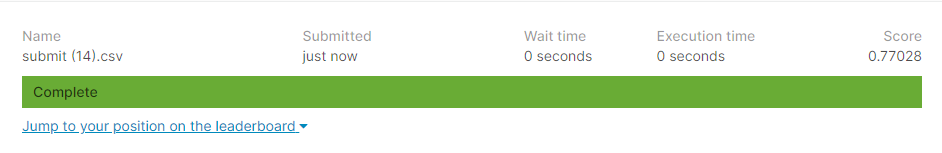

3.2.2 We changed our machine learning algorithm to a neural network. We had also added 5 new features that we believed could provide some useful information. We calculated the Population rate of change since counties with more people entering could indicate a growing younger population/families where young people and women tend to vote democratic. Bachelor's degree to unemployment ratio since this could indicate a higher educated population, and especially young people without jobs but with bachelor's degrees. An estimate on total population income per year a rough estimate to calculate whether there are many high-paying jobs and less of a blue-collar working county. The ratio of educated to unemployed relative multiplied by the median income since this could suggest how much bachelor’s impact the median income suggesting either a low skilled work. Finally, we included a change in the ratio among the newly educated population which could suggest again of new and younger people entering a county which I have previously mentioned.


<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [ ]:
# TODO

# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.

#model_to_use = clf_svm_k
#model_to_use.fit(df_norm, y)

best_val_acc_model_weights = torch.load(save_file)
model.load_state_dict(best_val_acc_model_weights)

y_pred = np.argmax(model(torch.tensor(x_test).float()).detach().numpy(), axis=1)
print("NN:",weighted_accuracy(y_pred, y_test_f))


df_t, df_t_clean, df_t_norm, df_t_norm_f = prep("/content/test_2016_no_label.csv", mean, std)


#y_submit = model_to_use.predict(df_t_norm_f)

y_s = model(torch.tensor(df_t_norm_f).float()).detach().numpy()
y_s = np.argmax(y_s, axis=1)

#Prep Data to be loaded into the csv
df_submit= pd.DataFrame(df_t_clean[:, 0].astype(int))
df_submit['FIPS']= pd.DataFrame(df_t_clean[:, 0].astype(int))
df_submit['Result'] = y_s
df_submit = df_submit.drop(0, axis = 1)
df_submit.to_csv(r"/content/submit.csv",  index = False)

len(pd.DataFrame(y_s)[pd.DataFrame(y_s)[0] == 1])




NN: 0.7444616977225672


208

<h2>Part 5: Resources and Literature Used</h2><p>